# Car accident severity predictor

This is the project report by Katharina Egert, submitted October 2020.

## 1. Introduction

The objective of this project is to create a way to predict severity of car accidents happening based on road and weather conditions.
That is, our algorithm needs to take as input the conditions that may impact severity of accidents:

* road conditions
* weather conditions
* lighting conditions

etc.

and predict the risk profile of potential accidents, i.e. the severity label. A user should then be able to specify the current conditions
of their itinerary and should then get back the severity label of accidents happening.

Example: A wet road should potential lead to higher severity accidents than a dry road.

The main stakeholders are:

* __traffic regulators__: They can make policies (e.g. speed limits, higher controls etc) in order to mitigate risks.
* __drivers__: They can recognize risks in advance and adapt their behavior in order to lower their own personal risks, e.g. drive more carefully or even avoid travelling at at risk conditions all together.


In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore') # just for the sake of beauty


## 2. Data 

In this section we will descibe the underlying data.

### 2.1 Data Source

The given data set contains all collisions provided by Seattle police departement and recorded by Traffic Records. The level of aggregation is
weekly. The timeframe is 2004 to today.
(See metadata from the SPD Collision data set.)

### 2.2 Data Loading
In the next step, we load the data into the notebook and display the first 5 lines of the raw table. Not all columns will be used and some will need to be transformed in order to be exploitable for our later classification.

In [51]:
full_df = pd.read_csv("../Collisions.csv", low_memory=False)
print(full_df.columns)
full_df.head()

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,...,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,...,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,...,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


### 2.3 Data Description

The problem consists in predicting accident severity based on outer conditions of accidents recorded. 
The label to be predicted is 'SEVERITYCODE'. A description of the severity is contained in the column 'SEVERITYDESC' and 'SEVERITYCODE.1'
which is therefore redundant.



The following columns are of a technical nature and therefore of no use to us:

* 'OBJECTID',
* 'INCKEY', 
* 'COLDETKEY', 
* 'REPORTNO',
* 'STATUS'
* 'INTKEY'
* 'EXCEPTRSNCODE',
* 'EXCEPTRSNDESC'

There are several other fields in the data which might be good predictors for severity, however it does not make sense to use these for this problem as traffic planers as well as drivers will not be able to input this data when using this analysis. Example: for pedestrian/cyclist count (which is actually depending on the dependent variable!) as one will not know how many pedestrians/bikes will be on the road on a given day. 

The total list of colums concerned is:
* 'PERSONCOUNT', 
* 'PEDCOUNT', 
* 'PEDCYLCOUNT', 
* 'VEHCOUNT',
* 'INATTENTIONIND',
* 'HITPARKEDCAR',
* 'HITPARKEDCAR',
* 'PEDROWNOTGRNT',
* 'SDOTCOLNUM', 
* 'ST_COLCODE', 
* 'ST_COLDESC',
* 'SEGLANEKEY', 
* 'CROSSWALKKEY',
* 'SDOT_COLCODE'
* 'SDOT_COLDESC',
* 'COLLISIONTYPE',

The colums that can be explored are
* 'ADDRTYPE', 'X', 'Y'
* 'LOCATION',
* 'INCDATE' and 'INCDTTM',
* 'JUNCTIONTYPE',
* 'WEATHER'
* 'ROADCOND', 
* 'LIGHTCOND'
* 'UNDERINFL'
* 'SPEEDING'
       
  



# 3. Methodology
This section represents the main component of the report where I will discuss and describe exploratory data analysis and inferential statistical testing performed.


### 3.1 Label analysis
We need to predict severity of the accident given by the data colum 'SEVERITYCODE'. The following codes are given:

* 3—fatality 
* 2b—serious injury
* 2—injury
* 1—property damage
* 0—unknown



We will now analyze the frequency of their occurrences. The first static gives the absolute frequency, the second one the relative frequency.

In [52]:
# first preprocessing: select columns to reduce size
df = full_df[['SEVERITYCODE', 'ADDRTYPE', 'LOCATION','INCDATE', 'INCDTTM','JUNCTIONTYPE','WEATHER','ROADCOND', 'LIGHTCOND','UNDERINFL','SPEEDING']]
# drop missing and unknown severity codes
df = df.dropna(subset=['SEVERITYCODE'])
df = df[df['SEVERITYCODE']!= "0"] 

We check now the total frequency of occurrences.

In [53]:
df['SEVERITYCODE'].value_counts()

1     137776
2      58842
2b      3111
3        352
Name: SEVERITYCODE, dtype: int64

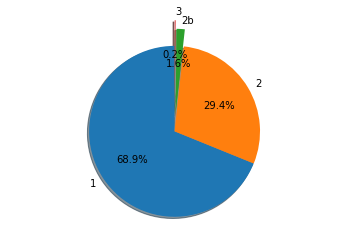

1     0.688601
2     0.294091
2b    0.015549
3     0.001759
Name: SEVERITYCODE, dtype: float64

In [54]:
explode = (0, 0, 0.2, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = df['SEVERITYCODE'].unique().tolist()
values = df['SEVERITYCODE'].value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
df['SEVERITYCODE'].value_counts().apply(lambda r: r/df['SEVERITYCODE'].count())

Overall, light accidents dominate by nearly 2/3 and the remainder is mostly light injuries. Heavy injuries consist only of 1.5% and fatalities about 0.2%, thus much more limited and thus much less significant data. 

This means that out data set is unbalanced, hence we need to try later on to account for this imbalance.

Secondly, for the algorithm to make sense from the stake holder point of view, it is much more important to detect the risk of potential injury-type accidents than misclassifiying an actual property damage case, since one is rather too careful than take too much risk. This will help us shape the cost function.


###  3.2 Feature selection

In this section, we will select the features which determine the features to use. For this we will first use business knowledge to select obvious factors and then also check which column seems to have the most impact on the severity outcome. 

* 'WEATHER' containing data on the weather such at if it was dry or wet etc.
* 'ROADCOND' containing information whether the road was dry, wet etc.
* 'LIGHTCOND' containing data on lighting, e.g. if it was dark.

We will check for these three first and eliminate unusable columns.

<!--

 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING',

Full colums
SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'-->
       
#### 'WEATHER'

We first check for the values.

In [55]:
df['WEATHER'].value_counts()

Clear                       114806
Raining                      34037
Overcast                     28555
Unknown                      15131
Snowing                        919
Other                          860
Fog/Smog/Smoke                 577
Sleet/Hail/Freezing Rain       116
Blowing Sand/Dirt               56
Severe Crosswind                26
Partly Cloudy                   10
Blowing Snow                     1
Name: WEATHER, dtype: int64

Now we're interested to see which of these conditions correlate with higher rates of severeness of accidents. Let's first have a look at absolute occurences and then relative frequencies.

In [56]:
print("Absolute Frequencies:")
#print(pd.crosstab(full_df['WEATHER'],full_df['SEVERITYCODE']))
cross = pd.crosstab(df['WEATHER'],df['SEVERITYCODE']).apply(lambda r: np.round(r/r.sum(),decimals=3), axis=1)
cross

Absolute Frequencies:


SEVERITYCODE,1,2,2b,3
WEATHER,,,,
Blowing Sand/Dirt,0.732,0.268,0.000,0.000
Blowing Snow,0.000,0.000,1.000,0.000
Clear,0.664,0.317,0.018,0.002
Fog/Smog/Smoke,0.664,0.326,0.005,0.005
Other,0.849,0.140,0.008,0.003
Overcast,0.672,0.310,0.016,0.002
Partly Cloudy,0.500,0.400,0.000,0.100
Raining,0.651,0.332,0.016,0.001
Severe Crosswind,0.692,0.269,0.000,0.038


In [57]:
# Some technical function to plot cross tabs later
def plot_cross(cross):
    """ Plots a cross matrix"""
    fig = plt.figure(figsize=[16,9])
    ax1 = fig.add_subplot(221)

    ax1.set_title("1 - Property Damage")

    ax2 = fig.add_subplot(222)
    ax2.set_title("1 - Light Injuries")

    ax3 = fig.add_subplot(223)
    ax3.set_title("2b - Serious Injuries")

    ax4 = fig.add_subplot(224)
    ax4.set_title("3 - Fatalities")

    cross['1'].plot(ax=ax1, color = ['blue'], kind='bar')
    cross['2'].plot(ax=ax2, color = ['orange'], kind='bar')
    cross['2b'].plot(ax=ax3, color = ['red'], kind='bar')
    cross['3'].plot(ax=ax4, color = ['black'], kind='bar') 
    
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    fig.subplots_adjust(hspace=0.8)

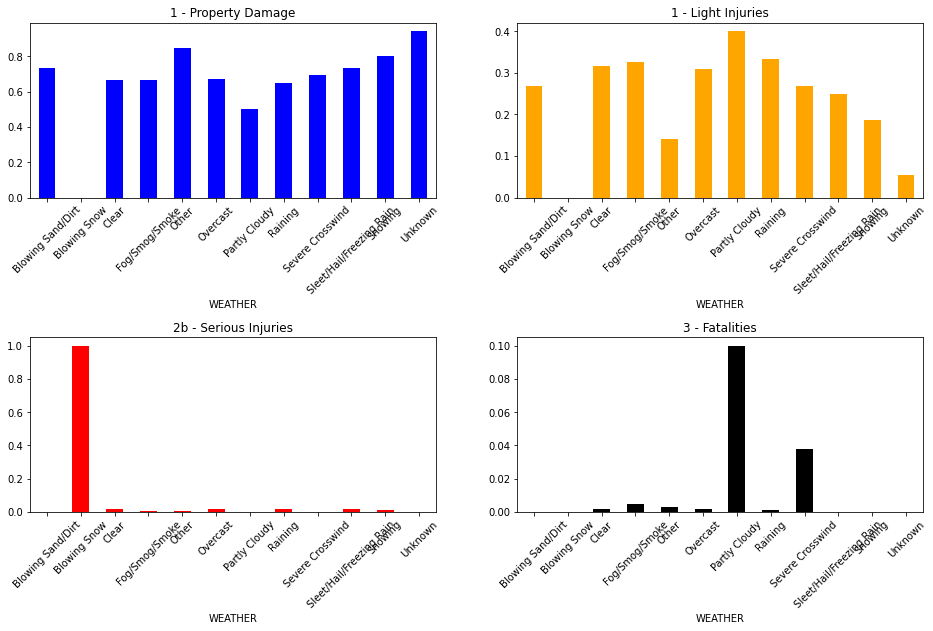

In [58]:
plot_cross(cross)

We see again heavy imbalanced-ness of the data. We can mitigate this by using out domain knowledge to group the data appropriately.

In [59]:
weather_dict = {'Clear': 'mild','Overcast':'mild','Partly Cloudy':'mild', \
                'Snowing' : 'bad', \
                'Sleet/Hail/Freezing Rain': 'bad', \
                'Blowing Sand/Dirt': 'bad',  'Severe Crosswind': 'bad', \
                'Raining': 'raining', \
                'Unknown': 'unknown',  'Other': 'unknown'               
               }
df['WEATHER'] = df['WEATHER'].map(weather_dict)
#print("Relative Frequencies by severity:")
cross = pd.crosstab(df['WEATHER'],df['SEVERITYCODE'])#.apply(lambda r: np.round(r/r.sum(),decimals=3), axis=1)

We check the frequencies now visually.


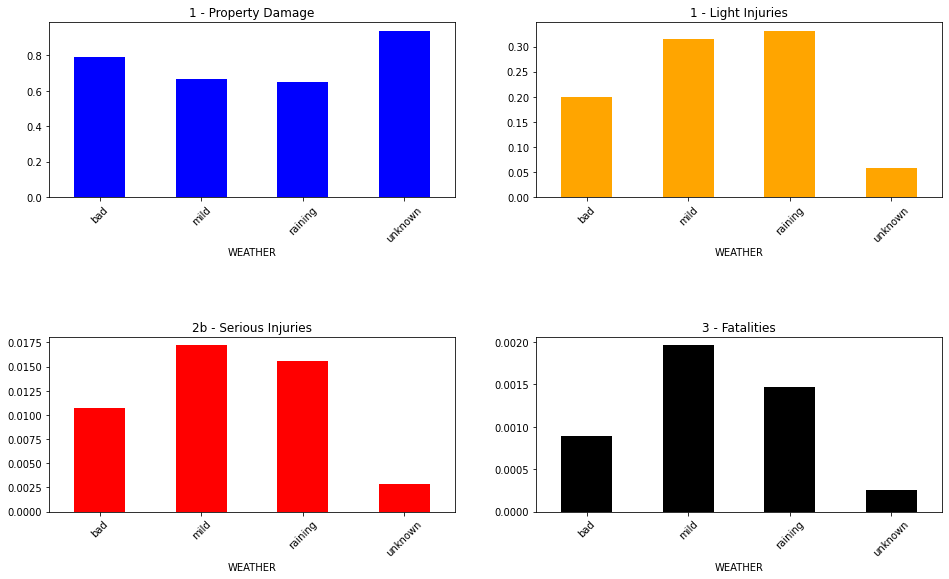

In [60]:
cross = pd.crosstab(df['WEATHER'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
plot_cross(cross)

__Observations:__

1. Most accidents happen at clear, overcast weather ('mild') or when it's raining. This is no surprise as these are the most common weather situations.
1. Most fatalities and heavy injuries also happen at mild weather or when it's raining.
1. Bad conditions such as snowing, while intuitively making up for a big risk, has actually a lower risk for severity. Perhaps drivers are already taking this risk into account and drive more carefully.
1. The most fatal weather is partly cloudy, having however not much data.

__Key takeaway__

Severe accidents happen most when it's raining or mild. Really adverse conditions are more associated with property damage or, a bit higher than for other conditions, mild injuries.


### 'ROADCOND'

We do the exact same thing for road conditions. We'll start with frequency.

In [61]:
df['ROADCOND'].value_counts()

Dry               128660
Wet                48734
Unknown            15139
Ice                 1232
Snow/Slush          1014
Other                136
Standing Water       119
Sand/Mud/Dirt         77
Oil                   64
Name: ROADCOND, dtype: int64

We note that, again, the main categories 'Dry' and 'Wet' dominate a lot the dataset. The two last categories have hardly enough data points. We check now for absolute and relative frequencies per severity code.

In [62]:
print("Absolute frequency:")
pd.crosstab(df['ROADCOND'],df['SEVERITYCODE'])

Absolute frequency:


SEVERITYCODE,1,2,2b,3
ROADCOND,,,,
Dry,85505,40644,2243,268
Ice,938,275,18,1
Oil,40,24,0,0
Other,90,43,3,0
Sand/Mud/Dirt,54,23,0,0
Snow/Slush,839,167,8,0
Standing Water,86,30,3,0
Unknown,14353,755,30,1
Wet,32000,15906,759,69


In [63]:
print("Relative frequency:")
cross = pd.crosstab(df['ROADCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
cross

Relative frequency:


SEVERITYCODE,1,2,2b,3
ROADCOND,,,,
Dry,0.664581,0.315902,0.017434,0.002083
Ice,0.761364,0.223214,0.014610,0.000812
Oil,0.625000,0.375000,0.000000,0.000000
Other,0.661765,0.316176,0.022059,0.000000
Sand/Mud/Dirt,0.701299,0.298701,0.000000,0.000000
Snow/Slush,0.827416,0.164694,0.007890,0.000000
Standing Water,0.722689,0.252101,0.025210,0.000000
Unknown,0.948081,0.049871,0.001982,0.000066
Wet,0.656626,0.326384,0.015574,0.001416


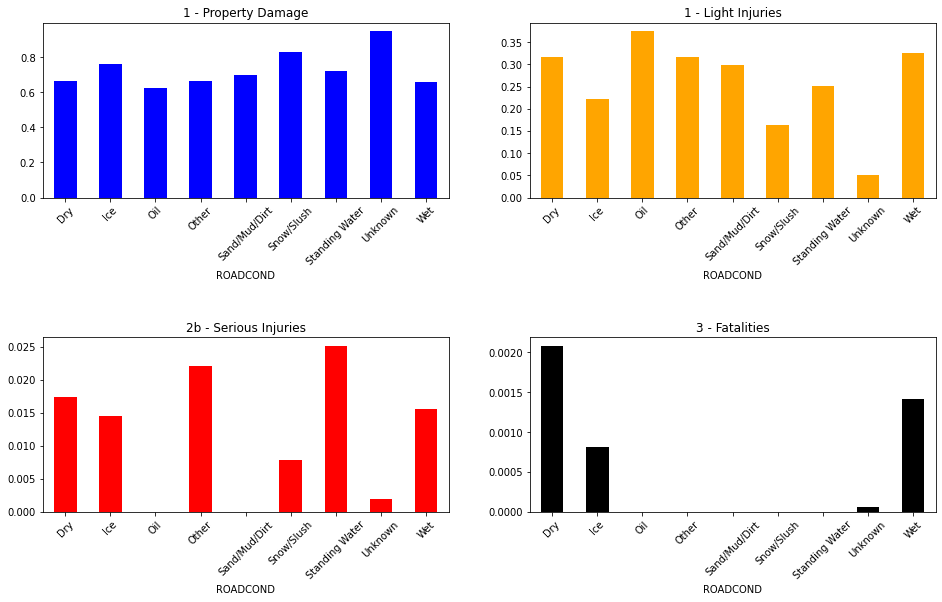

In [64]:
plot_cross(cross)

__Observations__

1. Wet and dry are again the most fatal categories, also in relative terms.
1. Adverse conditions seem to again favor property damage only accidents.
1. We can drop again unknown and other categories.

In [65]:
df = df[ (df['ROADCOND']!= "Unknown") & (df['ROADCOND']!= "Other")]
df = df.dropna(subset=['ROADCOND'])

After elimination of these columns, we have the following average severities.

In [66]:
df['SEVERITYCODE'].value_counts().apply(lambda r: r/df['SEVERITYCODE'].count())

1     0.664047
2     0.317226
2b    0.016848
3     0.001879
Name: SEVERITYCODE, dtype: float64

### 'LIGHTCOND'

We do the exact same thing for light conditions. We'll start with frequency.

In [67]:
df['LIGHTCOND'].value_counts()

Daylight                    116661
Dark - Street Lights On      48847
Dusk                          5893
Unknown                       2852
Dawn                          2547
Dark - No Street Lights       1486
Dark - Street Lights Off      1182
Other                          217
Dark - Unknown Lighting         22
Name: LIGHTCOND, dtype: int64

In [68]:
df.dropna(subset=['LIGHTCOND'], inplace=True)

In [69]:
cross = pd.crosstab(df['LIGHTCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
cross

SEVERITYCODE,1,2,2b,3
LIGHTCOND,,,,
Dark - No Street Lights,0.759085,0.223419,0.016824,0.000673
Dark - Street Lights Off,0.708122,0.264805,0.023689,0.003384
Dark - Street Lights On,0.679100,0.297091,0.020841,0.002968
Dark - Unknown Lighting,0.636364,0.363636,0.000000,0.000000
Dawn,0.649391,0.325088,0.023557,0.001963
Daylight,0.650903,0.332459,0.015198,0.001440
Dusk,0.651790,0.327847,0.017987,0.002376
Other,0.737327,0.244240,0.018433,0.000000
Unknown,0.904278,0.091515,0.003857,0.000351


__Observations:__

1. Our domain knowledge tells us, the darker the more risky.
1. Most accidents happen at daylight, so lighting does not fully explain higher severity accidents.
1. Most severe accidents happen in the dark.
1. Domain: Dusk/dawn are similar, also no streetlights when dark, so we can group these together.

We drop again 'Unknown', 'Other', 'Dark - Unknown Lighting' and missing values.


In [70]:
df = df[ (df['LIGHTCOND']!= "Unknown") & (df['LIGHTCOND']!= "Other") & (df['LIGHTCOND'] != "Dark - Unknown Lighting")]
df = df.dropna(subset=['LIGHTCOND'])


In [71]:
light_dict = {'Dark - No Street Lights' : 'dark - no lights', 'Dark - Street Lights Off': 'dark - no lights', \
              'Dark - Street Lights On' : 'dark with lights', \
              'Dawn': 'dusk/dawn', 'Dusk': 'dusk/dawn', \
              'Daylight': 'daylight'\
               }
df['LIGHTCOND'] = df['LIGHTCOND'].map(light_dict)

df['LIGHTCOND'].value_counts()


daylight            116661
dark with lights     48847
dusk/dawn             8440
dark - no lights      2668
Name: LIGHTCOND, dtype: int64

In [72]:
cross = pd.crosstab(df['LIGHTCOND'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
cross

SEVERITYCODE,1,2,2b,3
LIGHTCOND,,,,
dark - no lights,0.736507,0.241754,0.019865,0.001874
dark with lights,0.679100,0.297091,0.020841,0.002968
daylight,0.650903,0.332459,0.015198,0.001440
dusk/dawn,0.651066,0.327014,0.019668,0.002251


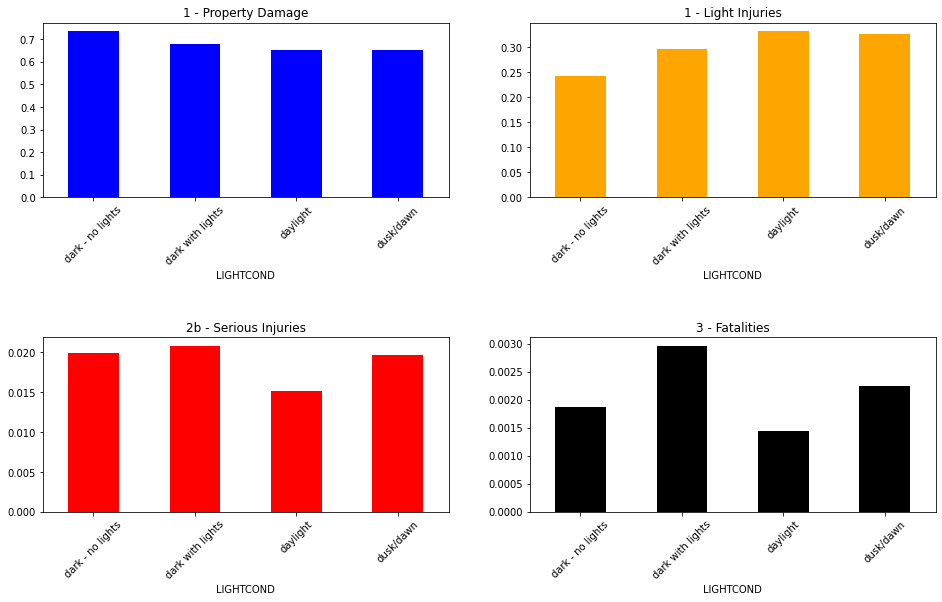

In [73]:
plot_cross(cross)

__Key observations:__ 

1. The most fatal conditions are dark nights with lighting followed by dusk and dawn. 
1. Most safest to drive is daylight follwed by dark with no lights, where there are probably less people on the route. 

### Time dimension

We do get a timing dimension via 'INCDTTM'. First, we need to cast this column as datetime.

In [74]:
df['INCDTTM'].head()
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df['INCDTTM'].head()

0   2020-01-19 09:01:00
1   2005-04-11 18:31:00
2   2013-03-31 02:09:00
3   2020-01-06 17:55:00
4   2009-12-25 19:00:00
Name: INCDTTM, dtype: datetime64[ns]

Next, we extract dates (for our time series), extract the hour as well as the weekday.

In [75]:
df['date'] = df['INCDTTM'].dt.date
df['yearmonth'] = str(df['INCDTTM'].dt.year) + "-" + str(df['INCDTTM'].dt.month)
df['hour'] = df['INCDTTM'].dt.hour
df['weekdaynum'] = df['INCDTTM'].dt.weekday

dict_weekday = {0 : '1 - Monday', 1: '2 - Tuesday', \
                2 : '3 - Wednesday',  3 : '4 - Thursday',\
                4 : '5 - Friday',  5 : '6 - Saturday', 6 : '7 - Sunday'
               }
df['weekday'] = df['weekdaynum'].map(dict_weekday)

#### Dates


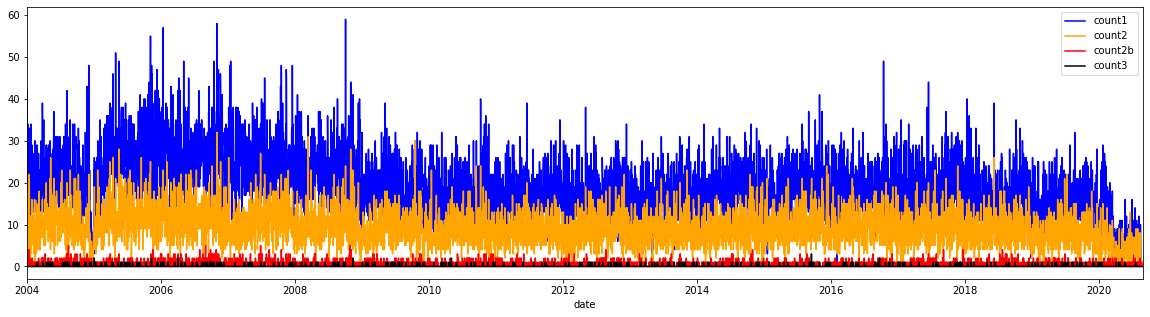

In [76]:
df['count1'] = df['SEVERITYCODE'].apply(lambda x: 1 if (x == '1') else 0)
df['count2'] = df['SEVERITYCODE'].apply(lambda x: 1 if (x == '2') else 0)
df['count2b'] = df['SEVERITYCODE'].apply(lambda x: 1 if (x == '2b') else 0)
df['count3'] = df['SEVERITYCODE'].apply(lambda x: 1 if (x == '3') else 0)

ts = df[['date','count1','count2','count2b','count3']].groupby(['date']).sum()
ts.plot(figsize=[20,5],color=['blue','orange','red','black'])




__Observations__
1. We see a difference between years. Therefore it might make sense to introduce a per year variable.  
1. Additionally, there seems to be a by month seasonality and potentially a per week seasonality.

In [77]:
df['year'] = df['INCDTTM'].dt.year
df['month'] = df['INCDTTM'].dt.month

#### Years

We take a look at relative decomposition of accidents.


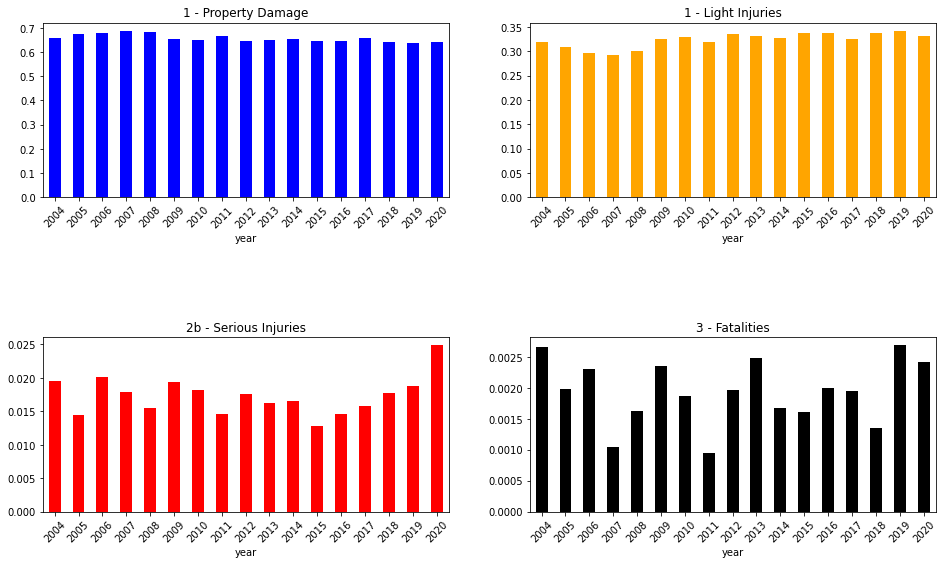

In [78]:
cross = pd.crosstab(df['year'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
plot_cross(cross)



In [79]:
pd.crosstab(df['year'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)

SEVERITYCODE,1,2,2b,3
year,,,,
2004,0.659143,0.318640,0.019561,0.002655
2005,0.674683,0.308906,0.014430,0.001981
2006,0.680042,0.297448,0.020203,0.002307
2007,0.687709,0.293330,0.017920,0.001041
2008,0.682837,0.300041,0.015491,0.001631
2009,0.653177,0.325115,0.019350,0.002357
2010,0.651407,0.328454,0.018271,0.001869
2011,0.665082,0.319286,0.014681,0.000951
2012,0.645121,0.335261,0.017656,0.001962


We sse that fatality rates vary with a factor two, while the other categories fluctuate, too, but a bit less. There is no clear linear trend, so we will need to use this variable categorically.

#### Month

In [80]:
cross = pd.crosstab(df['month'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
cross

SEVERITYCODE,1,2,2b,3
month,,,,
1,0.672813,0.308341,0.017281,0.001565
2,0.677759,0.304829,0.015710,0.001703
3,0.667260,0.312611,0.018691,0.001438
4,0.662796,0.320130,0.015001,0.002074
5,0.650234,0.332443,0.015108,0.002214
6,0.664454,0.318340,0.016046,0.001160
7,0.642606,0.335394,0.020307,0.001692
8,0.644413,0.333200,0.020194,0.002192
9,0.656129,0.325083,0.016292,0.002496


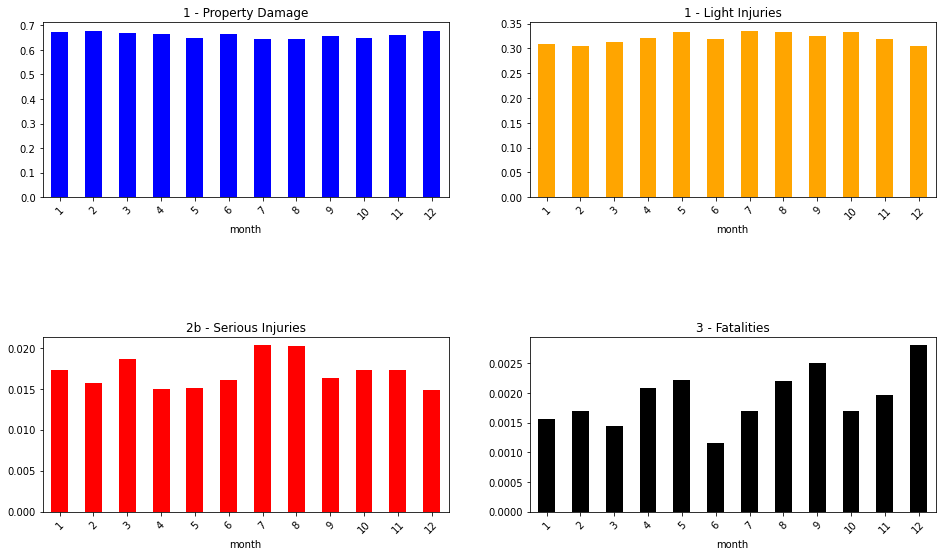

In [81]:
plot_cross(cross)

__Observations__

* Here we see a seasonality trend for winter and summer for property damage and light injuries, less so for serious injuries and fatalities.
* Fatalities grow at the end of year.
* There is no linear relationship, so we cannot use a numerical variable.

In [82]:
df['month'] = df['month'].astype("|S")

#### Hour

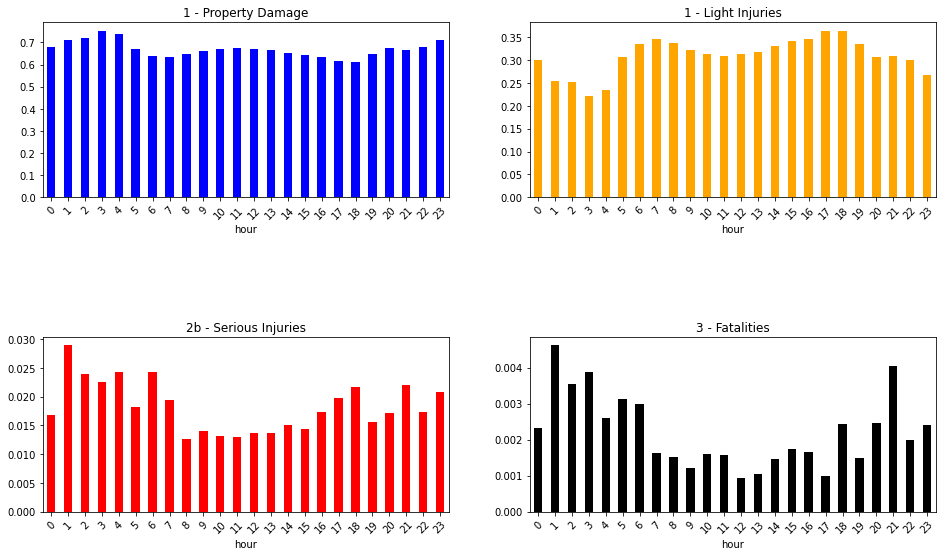

In [83]:
cross = pd.crosstab(df['hour'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
plot_cross(cross)

__Observations:__

1. During the day less serious accidents happen. 
1. At night, the peak hour for sever accidents is 1am.
1. The safest timeframe is in the morning.
1. The relationship is not linear, hence we cannot use it as a standard numerical variable.

In [84]:
df['hour'] = df['hour'].astype("|S")

#### Weekday

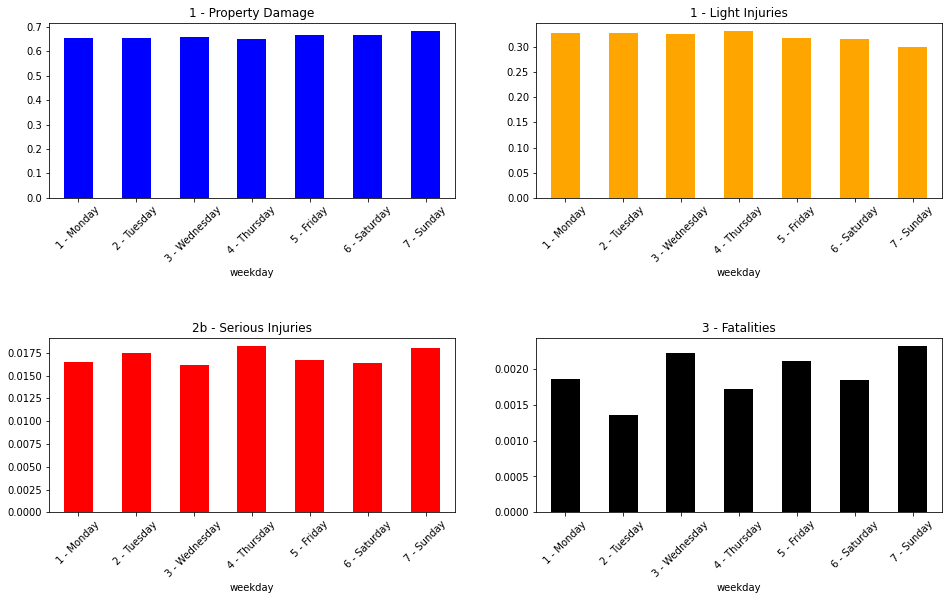

In [85]:
cross = pd.crosstab(df['weekday'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)#.plot(kind='bar')
plot_cross(cross)

__Obervations:__

1. Tuesday is safest for fatalities, while Wednesdays and Sundays pose the highest risk.
1. All other weekdays are pretty much equal.



### Location type

As a driver, one knows that accidents are more likely at intersections. This information is stored in the variable 'ADDRTYPE'. 

In [86]:
df['ADDRTYPE'].value_counts()

Block           111205
Intersection     64054
Alley              618
Name: ADDRTYPE, dtype: int64

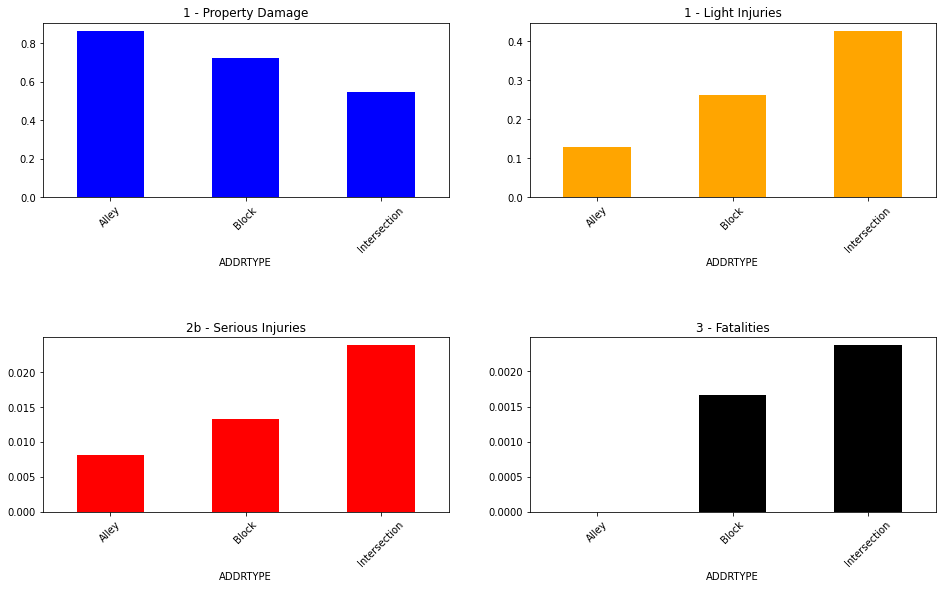

In [87]:
cross = pd.crosstab(df['ADDRTYPE'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
plot_cross(cross)

__Observations__ 

* Most deaths and serious injuries happen at intersections and blocks.
* Alleys are more prone for property damage.


### 'UNDERINFL'

We see that the data is not quite clean and we need to group it together.

In [88]:
df['UNDERINFL'].value_counts()


N    93557
0    73538
Y     5336
1     4185
Name: UNDERINFL, dtype: int64

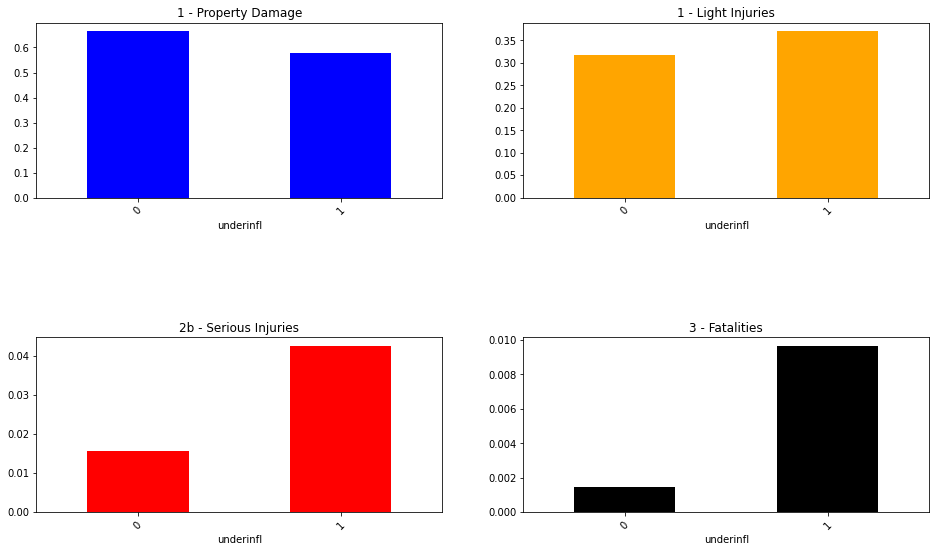

In [89]:
df['underinfl'] = df['UNDERINFL'].apply(lambda x: 1 if ((x == '1') | (x == 'Y'))  else 0)
cross = pd.crosstab(df['underinfl'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
plot_cross(cross)


__Observations__

* Not surprisingly, under influence of drugs and alcohol, serious injuries and fatalities are more likely. 
* Here traffic managers may administer more drug testing in order to make these driving conditions safer.


### 'SPEEDING'

Here, we take the same steps as for UNDERINFL.

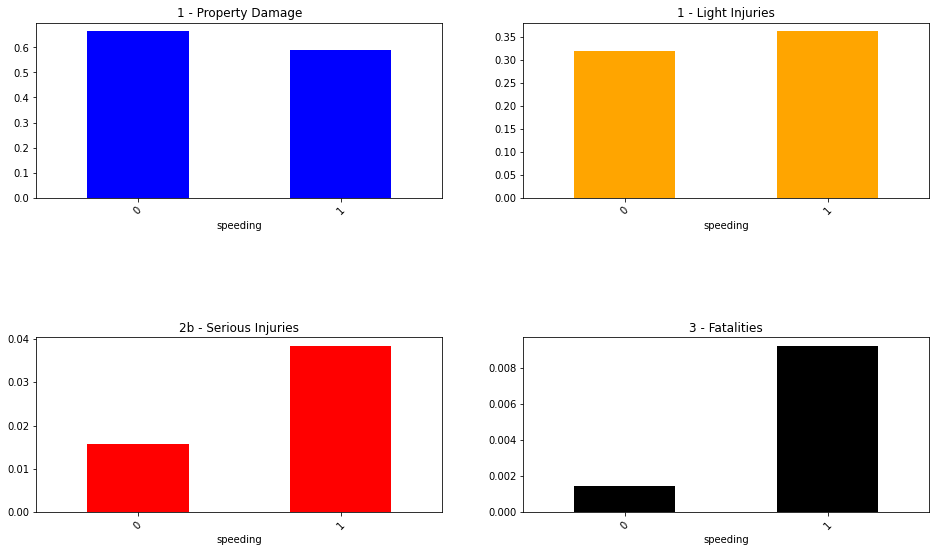

In [90]:
df['SPEEDING'].value_counts()
df['speeding'] = df['SPEEDING'].apply(lambda x: 1 if (x == 'Y')  else 0)
cross = pd.crosstab(df['speeding'],df['SEVERITYCODE']).apply(lambda r: r/r.sum(), axis=1)
plot_cross(cross)


__Observations__

Here, the same conclusion as for under influence: Serious injuries and fatalities rise when speeding.

#### Feature summary

We will therefore use

* WEATHER (transformed)
* ROADCOND
* LIGHTCOND (transformed)
* hour (transformed from date)
* weekday (transformed from date)
* month
* ADDRTYPE
* speeding
* underinfl


We therefore reduce the columns as follows:

In [91]:
df = df[['SEVERITYCODE','WEATHER','ROADCOND','LIGHTCOND','hour', 'weekday', 'ADDRTYPE','year','month','speeding','underinfl']]
df.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,hour,weekday,ADDRTYPE,year,month,speeding,underinfl
0,1,mild,Dry,daylight,b'9',7 - Sunday,Intersection,2020,b'1',0,0
1,1,raining,Wet,dusk/dawn,b'18',1 - Monday,Block,2005,b'4',0,0
2,2,mild,Dry,dark with lights,b'2',7 - Sunday,Block,2013,b'3',0,0
3,2,raining,Wet,dark with lights,b'17',1 - Monday,Intersection,2020,b'1',0,0
4,2,mild,Ice,dark with lights,b'19',5 - Friday,Block,2009,b'12',1,0


First we convert the categorical data into dummy variables encoding our categorical variables.

In [92]:
dummy_columns = ['WEATHER','ROADCOND','LIGHTCOND','hour', 'weekday', 'ADDRTYPE','year','month']
data = pd.get_dummies(df,columns=dummy_columns)
data.head()

,SEVERITYCODE,speeding,underinfl,WEATHER_bad,WEATHER_mild,WEATHER_raining,WEATHER_unknown,ROADCOND_Dry,ROADCOND_Ice,ROADCOND_Oil,...,month_b'11',month_b'12',month_b'2',month_b'3',month_b'4',month_b'5',month_b'6',month_b'7',month_b'8',month_b'9'
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### 3.3 Machine learning models

We will try several variants of machine learning models.

* Logistic Regression
* Random Forests


#### 3.3.1 Creating Balance

First of all, we need to find a way to deal with the imbalanced-ness of data. This can be handled via weights for logistic regression reflecting the frequency of occurrence.

In [94]:
weight1 = len(data) / (len(data[data['SEVERITYCODE'] == '1'])*2)
weight2 = len(data) / (len(data[data['SEVERITYCODE'] == '2'])*2)
weight2b = len(data) / (len(data[data['SEVERITYCODE'] == '2b'])*2)
weight3 = len(data) / (len(data[data['SEVERITYCODE'] == '3'])*2)

print("Weight1: " + str(weight1))
print("Weight2: " + str(weight2))
print("Weight2b: " + str(weight2b))
print("Weight3: " + str(weight3))

weights = {'1':weight1, '2':weight2, '2b':weight2b, '3':weight3}

Weight1: 0.7575728979899972
Weight2: 1.5574053825261895
Weight2b: 29.338205980066444
Weight3: 262.0415430267062


#### 3.3.2 Train-test-split

Secondly, we need to split the data into a train and test set.

In [95]:
X = data.drop('SEVERITYCODE', axis=1).values
#X = preprocessing.StandardScaler().fit(X).transform(X)
y = data['SEVERITYCODE']

In [96]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=10)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (141292, 80) (141292,)
Test set: (35324, 80) (35324,)


#### 3.3.3 Logistic Regression

Here, we model the probability of a feature set to result in either category. This algorithm is designed for binary decision problems, which is the case for this data set and the posed question.

__Model tuning__ We tune model performance by testing several hyperparameters using RandomizedSearchCV.


In [97]:
LR = LogisticRegression(class_weight=weights)
LR.fit(X_train,y_train)

LogisticRegression(C=1.0,
          class_weight={'1': 0.7575728979899972, '2': 1.5574053825261895, '2b': 29.338205980066444, '3': 262.0415430267062},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

We try a first, naive, logistic regression without tuning.

In [98]:
y_hat_lg = LR.predict(X_test)
print("Classification Report: Logistic Regression")
print(classification_report(y_test, y_hat_lg))
print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_hat_lg, normalize=True)*100,2)) + "% (correctly classified test data)")
print("F1: " + str(round(metrics.f1_score(y_test, y_hat_lg, average='weighted'),6))+ " (weighted average of recall and precision)")


Classification Report: Logistic Regression
              precision    recall  f1-score   support

           1       0.72      0.73      0.72     23348
           2       0.43      0.34      0.38     11307
          2b       0.05      0.03      0.03       586
           3       0.01      0.31      0.02        83

   micro avg       0.59      0.59      0.59     35324
   macro avg       0.30      0.35      0.29     35324
weighted avg       0.61      0.59      0.60     35324

Accuracy: 59.16% (correctly classified test data)
F1: 0.599509 (weighted average of recall and precision)


In [99]:
reg_params = {
    'penalty': ['l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['newton-cg','saga','lbfgs']
}

scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')

randomized_cv = RandomizedSearchCV(
    LogisticRegression(class_weight=weights),
    param_distributions=reg_params,
    cv=3,
    scoring=scorer,
    verbose=5,
    n_jobs=-1,
    random_state=0
)

randomized_cv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0,
          class_weight={'1': 0.7575728979899972, '2': 1.5574053825261895, '2b': 29.338205980066444, '3': 262.0415430267062},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'penalty': ['l2'], 'C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]), 'solver': ['newton-cg', 'saga', 'lbfgs']},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=

In [100]:
y_hat_lg = randomized_cv.predict(X_test)
print("Classification Report: Logistic Regression")
print(classification_report(y_test, y_hat_lg))
print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_hat_lg, normalize=True)*100,2)) + "% (correctly classified test data)")
print("F1: " + str(round(metrics.f1_score(y_test, y_hat_lg, average='weighted'),6))+ " (weighted average of recall and precision)")


Classification Report: Logistic Regression
              precision    recall  f1-score   support

           1       0.73      0.62      0.67     23348
           2       0.42      0.28      0.33     11307
          2b       0.03      0.17      0.04       586
           3       0.01      0.41      0.02        83

   micro avg       0.50      0.50      0.50     35324
   macro avg       0.30      0.37      0.27     35324
weighted avg       0.62      0.50      0.55     35324

Accuracy: 49.91% (correctly classified test data)
F1: 0.549666 (weighted average of recall and precision)


Note that in this optimized version, recall for "2b" and "3" is better.

#### 3.3.4 Random Forests

Random forests are a good candidate because they are very versatile and will allow us to work with out categorical data.

In [102]:
rf_params = {
    'max_depth': [2, 5, 10, 20],
    'max_features': [5, 7, 10, 15],
    'n_estimators': [100, 200, 500, 700],
    'min_samples_split': [10, 15, 20]
}

scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')

randomized_cv = RandomizedSearchCV(
    RandomForestClassifier(class_weight=weights),
    param_distributions=rf_params,
    cv=3,
    scoring=scorer,
    verbose=5,
    n_jobs=-1,
    random_state=0
)

randomized_cv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={'1': 0.7575728979899972, '2': 1.5574053825261895, '2b': 29.338205980066444, '3': 262.0415430267062},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0....rs='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [2, 5, 10, 20], 'max_features': [5, 7, 10, 15], 'n_estimators': [100, 200, 500, 700], 'min_samples_split': [10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn',
          scoring=make_scorer(f1_score, average=weighted), verbose=5)

We can then extract the best model and fit the data.

In [103]:
RF = randomized_cv.estimator
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True,
            class_weight={'1': 0.7575728979899972, '2': 1.5574053825261895, '2b': 29.338205980066444, '3': 262.0415430267062},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [104]:
y_hat_rf = randomized_cv.predict(X_test)
print("Classification Report: Random Forest")
print(classification_report(y_test, y_hat_rf))
print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_hat_rf, normalize=True)*100,2)) + "% (correctly classified test data)")
print("F1: " + str(round(metrics.f1_score(y_test, y_hat_rf, average='weighted'),6))+ " (weighted average of recall and precision)")


Classification Report: Random Forest
              precision    recall  f1-score   support

           1       0.73      0.68      0.70     23348
           2       0.42      0.46      0.44     11307
          2b       0.04      0.07      0.05       586
           3       0.02      0.05      0.03        83

   micro avg       0.60      0.60      0.60     35324
   macro avg       0.30      0.31      0.30     35324
weighted avg       0.62      0.60      0.60     35324

Accuracy: 59.52% (correctly classified test data)
F1: 0.604981 (weighted average of recall and precision)


So, random forests beat logistic regression in the F1-score. However, the recall for 2b and 3 is too low, hence we still choose Logistic regression.


## 4. Results
Out of our two approaches, logistic classification and random forests, we pick  logistic classification because of the better f1 score performance and the fact that the recall is better for severe injuries and fatalities.

### 4.1  Confusion matrix

The confusion matrix tells us how well our algorithm classifies our test data, e.g. for a given severity code, say fatalities, how many does the algorithm get right and puts into category 3 and how many does it put into other categories?

Confusion matrix, without normalization
[[14366  4176  2221  2585]
 [ 4997  3130  1649  1531]
 [  214   142   100   130]
 [   26    16     7    34]]


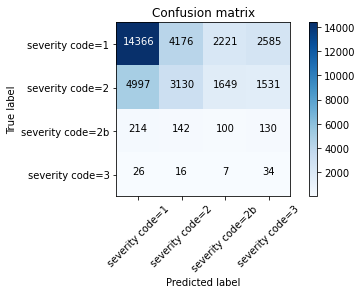

In [116]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_lg, labels=['1','2', '2b','3'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['severity code=1','severity code=2','severity code=2b','severity code=3'],normalize= False,  title='Confusion matrix')

### 4.2. Feature importance

An interesting side result of the machine learning models we used is that we can extract which features that is which attributes of the accidents play an important role in determining the accident's severity. We get both negative and positive factors: The higher a positive factor, the bigger the higher the likelyhood of an accident of this severity. A negative factor means that this severity is much less likely to happen in the presence of this flag.

Text(0.5, 1.0, 'Severity Code 1 - Property damage')

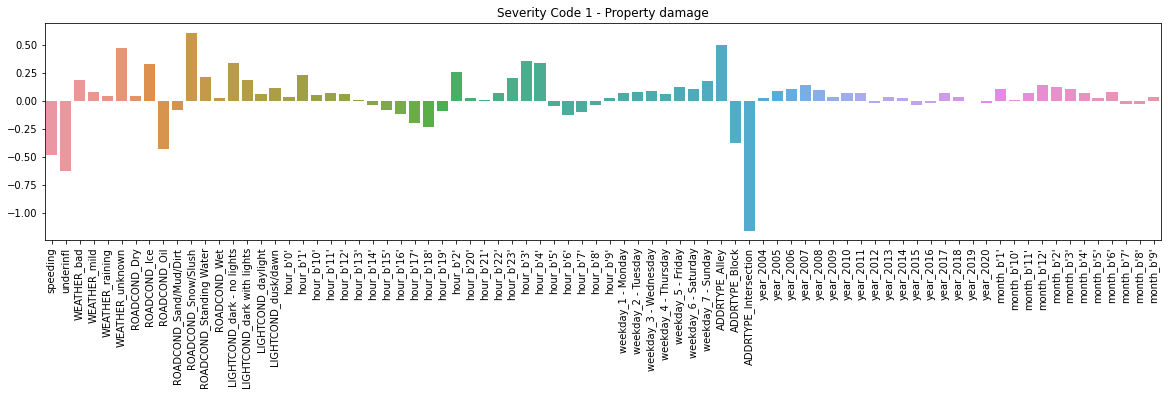

In [112]:
# Severity 1
importances = LR.coef_[0] #[abs(i) for i in LR.coef_[3]]#RF.feature_importances_] 0 corr to 1
data.drop('SEVERITYCODE', axis=1).columns.values
ax = sns.barplot(data.drop('SEVERITYCODE', axis=1).columns.values, importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_figwidth(20)
ax.set_title("Severity Code 1 - Property damage")

__Observations__

Property damage only accidents will __likely happen__ under the following conditions:

* Ice, snow/slush,
* Standing water,
* in alleys,
* between 2-4am.

Property damage only accidents are __less likely to happen__ under the following conditions:

* Blocks and intersections,
* in presence of speeding or intoxicated drivers.


Text(0.5, 1.0, 'Severity Code 2 - (Light) injuries')

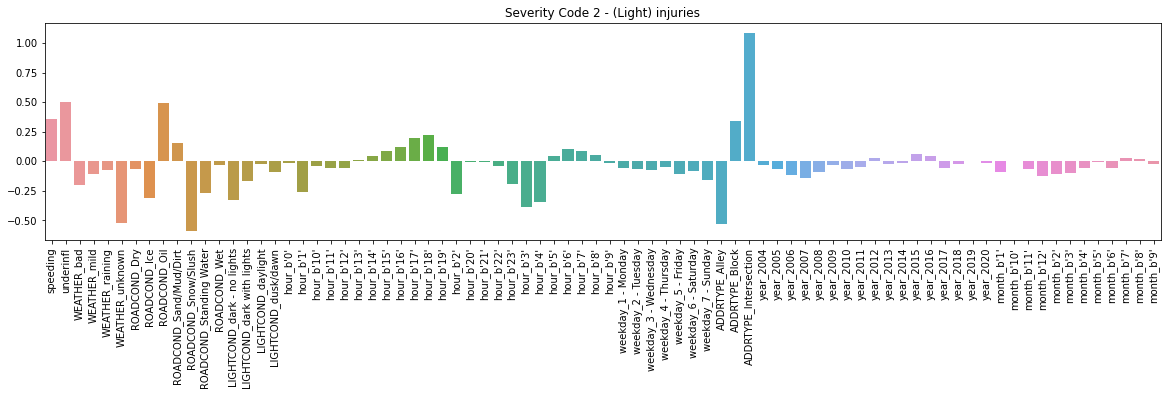

In [113]:
# Severity 2
importances = LR.coef_[1] #[abs(i) for i in LR.coef_[3]]#RF.feature_importances_] 0 corr to 1
data.drop('SEVERITYCODE', axis=1).columns.values
ax = sns.barplot(data.drop('SEVERITYCODE', axis=1).columns.values, importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_figwidth(20)
ax.set_title("Severity Code 2 - (Light) injuries")

__Observations__

Property damage only accidents will __likely happen__ under the following conditions:

* intersections and blocks,
* oil present,
* in presence of speeding or intoxicated drivers.

Property damage only accidents are __less likely to happen__ under the following conditions:

* ice, snow/slush, standing water
* in alleys,
* dark and no lights.

Text(0.5, 1.0, 'Severity Code 2b - Serious injuries')

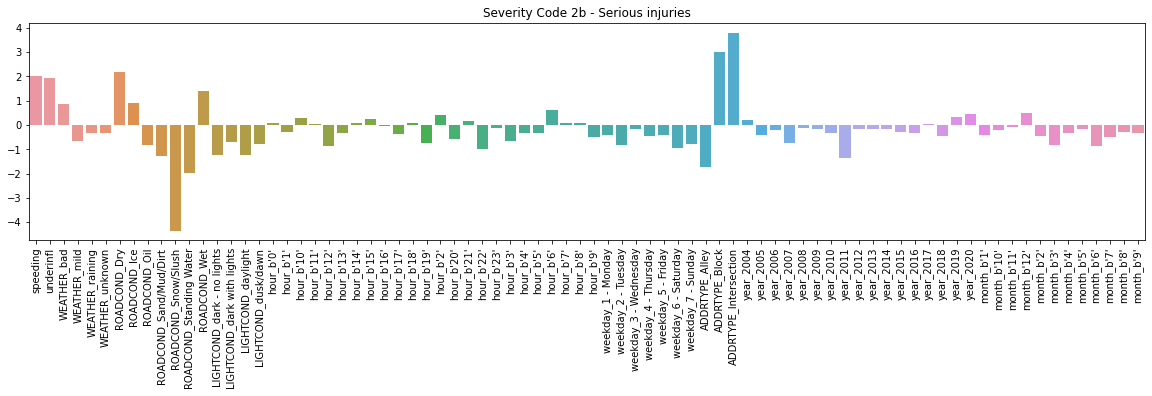

In [114]:
# Severity 2b
importances = LR.coef_[2] #[abs(i) for i in LR.coef_[3]]#RF.feature_importances_] 0 corr to 1
data.drop('SEVERITYCODE', axis=1).columns.values
ax = sns.barplot(data.drop('SEVERITYCODE', axis=1).columns.values, importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_figwidth(20)
ax.set_title("Severity Code 2b - Serious injuries")

__Observations__

Property damage only accidents will __likely happen__ under the following conditions:

* intersections and blocks,
* dry or wet roads,
* in presence of speeding or intoxicated drivers.

Property damage only accidents are __less likely to happen__ under the following conditions:

* snow/slush and standing water,
* in alleys,
* daylight, dusk and dawn.

Text(0.5, 1.0, 'Severity Code 3 - Fatalities')

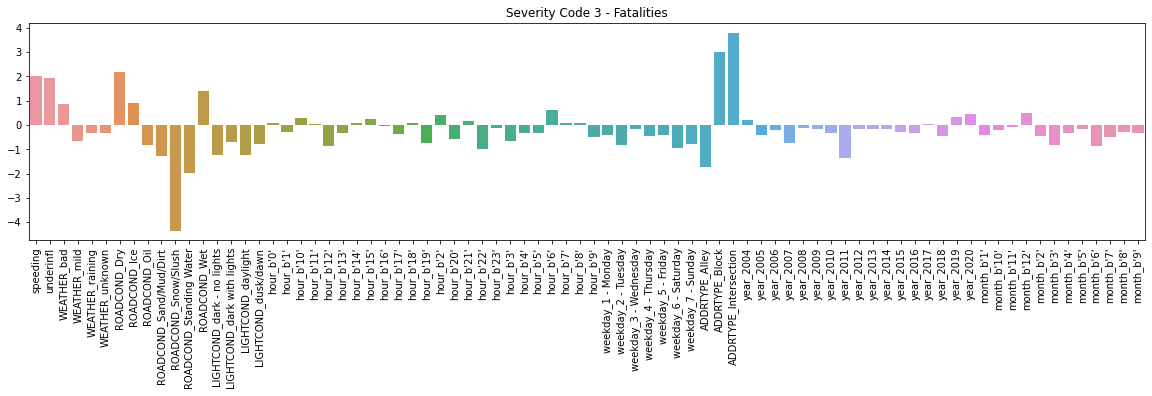

In [115]:
# Severity 3
importances = LR.coef_[3] #[abs(i) for i in LR.coef_[3]]#RF.feature_importances_] 0 corr to 1
data.drop('SEVERITYCODE', axis=1).columns.values
ax = sns.barplot(data.drop('SEVERITYCODE', axis=1).columns.values, importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.figure.set_figwidth(20)
ax.set_title("Severity Code 3 - Fatalities")

__Observations__

Property damage only accidents will __likely happen__ under the following conditions:

* intersections and blocks,
* dry, wet or icy roads,
* bad weather conditions,
* in presence of speeding or intoxicated drivers.

Property damage only accidents are __less likely to happen__ under the following conditions:

* snow/slush, dirt or standing water on the road,
* in alleys.


## 5. Discussion


### 5.1 Modeling

Our models work acceptably well to recognize code severe accidents. From a business point of view, correctly classifying higher severity accidents is of higher priority, so one might want to adapt the weights in the classifiers so that they get correctly classified at the expense of potentially misclassifying the lower severities.

Another way of improving our results would be to try and introduce numerical scales for adversity for road, light and weather conditions.

### 5.2 Accident severity

The most striking feature we notice in the feature importance analysis is the importance of intersections. They pose a major risk for injuries in accident.

Both speeding and driving under influence have been identified as high impactful for higher severity. While this is not something drivers themselves can influence for the other drivers, at least this can be given to them as warnings to adapt their own behavior. On the contrary, for traffic regulators, they might wish to instate higher regulatory measurements such as speed traps or mobile units testing drivers for intoxication.

Interestingly, drivers seem to already adapt their behavor already to obviously adverse road, light and weather conditions such as snowing, but fail to take into account medium type conditions such as rain where most severe accidents happen as well as during 'mild' conditions where these conditions seem to not play a big role.

From a timing perspective, the hours during the day are most safe, while driving at night, particularly around 1am seems to be most dangerous.



## 6. Conclusion

In this analysis, we have analyzed the question of what impacts accident severity based on the overall conditions the driver is
facing. We have used as basis the data collected by the Seattle police departement from 2004 to today. We have conducted
a data analysis and selected features that had most impact on the accident severity.

As predictive models, we have used logistic regression and random forests. Random forests performed better by f1 scoring, however recall of the higher categories (correctly identifying serious injuries and fatalities) was not good enough. So we picked logistic regression.

Both models suffer from lower recall for type 2 classifications. In a future analyis,this may be mitigated by using different weights.

Subsequently, we have analyzed feature importance and concluded that speeding, driving intoxicated, intersections and blocks are increasing one's risk in accidents.
